In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

2024-10-10 11:38:36.070291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 11:38:36.105297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 11:38:36.747447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#vamos aprende ler uma colecao de figuras

# Listar arquivos .png na pasta atual
current_directory = os.getcwd()+"/figuras/"
event_files = [f for f in os.listdir(current_directory) if (f.endswith('.png') and "event" in f)]
hit_files=[f for f in os.listdir(current_directory) if (f.endswith('.png') and "hit" in f)]

event_files=sorted(event_files)
hit_files=sorted(hit_files)

In [4]:
n_figuras=1000
n_total=len(event_files)

random=np.random.choice(n_total,n_figuras,replace=False)

x=[]
y=[]
x_teste=[]


x_end=32
y_end=32

for j in range(n_figuras):
    x.append(np.divide(np.array(Image.open(current_directory+event_files[j]).convert('L'))[0:x_end,0:y_end],215))
    y.append(np.divide(np.array(Image.open(current_directory+hit_files[j]).convert('L'))[0:x_end,0:y_end],215))

In [5]:
#separando em treino e teste dados

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)
#x_train,x_test,y_train,y_test = train_test_split(x,x_teste,random_state=42)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

x_train = x_train.reshape((-1, x_end,y_end, 1))
x_test = x_test.reshape((-1, x_end,y_end, 1))
y_train = y_train.reshape((-1, x_end,y_end, 1))
y_test = y_test.reshape((-1, x_end,y_end, 1))

x=None
y=None


In [6]:
# Encoder
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(x_end, y_end, 1), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
])

# Decoder
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', kernel_initializer="he_normal", padding='same'),
])

# Autoencoder
autoencoder2 = tf.keras.Sequential([encoder, decoder])
autoencoder2.compile(loss='mean_squared_error', optimizer='adam')
autoencoder2.summary()


/home/gabriel/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 4, 4, 256)      │       369,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,664 (1.41 MB)

 Trainable params: 369,664 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = autoencoder2.fit(x_train,x_train, epochs=50, batch_size=10, validation_data=[x_test,x_test])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.6007e-05 - val_loss: 8.2390e-05
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.0960e-05 - val_loss: 8.7592e-05
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.2862e-05 - val_loss: 8.3055e-05
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.0637e-05 - val_loss: 8.3765e-05
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.0497e-05 - val_loss: 8.2434e-05
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.7319e-05 - val_loss: 8.6132e-05
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.9511e-05 - val_loss: 8.7362e-05
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.9912e-05 - val_loss: 9.3284e-05
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.0078e-05 - val_loss: 8.0736e-05
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.6629e-05 - val_loss: 8.3546e-05
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.8917e-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


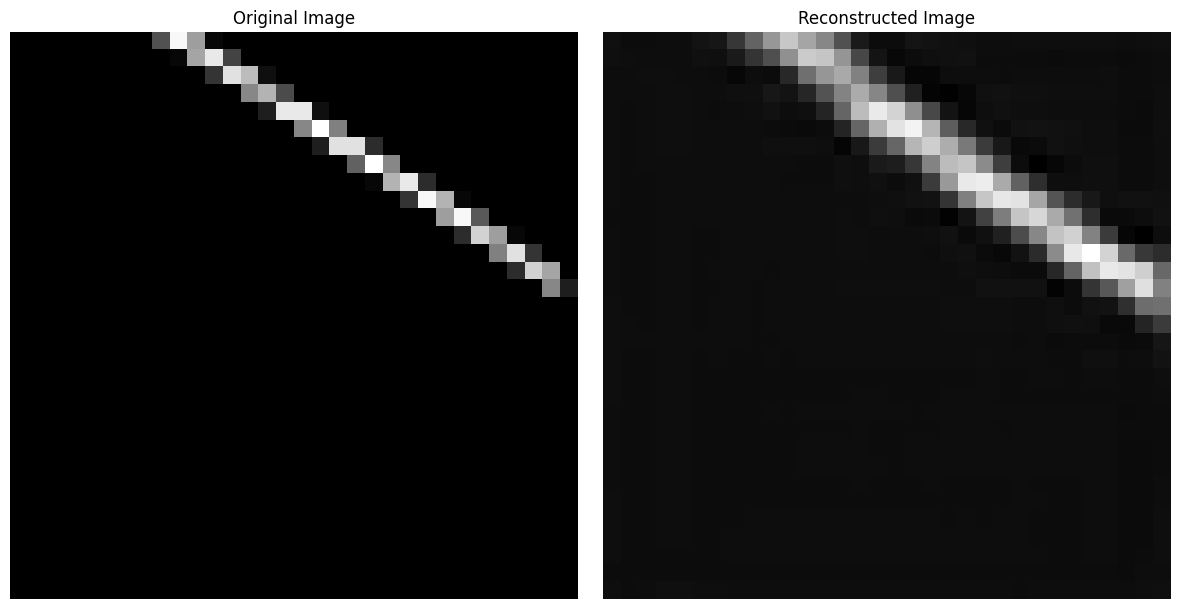

In [46]:
index=6
a=autoencoder2.predict(np.expand_dims(x_test[index], axis=0))
# Visualizar o primeiro exemplo
plt.figure(figsize=(12, 6))
# Exibir a imagem original
plt.subplot(1, 2, 1)
plt.imshow(x_test[index], cmap='gray')  # Adapte o cmap se necessário
plt.title('Original Image')
plt.axis('off')  # Desliga os eixos
# Exibir a imagem reconstruída
plt.subplot(1, 2, 2)
plt.imshow(a[0], cmap='gray')  # Adapte o cmap se necessário
plt.title('Reconstructed Image')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()
plt.show()



In [47]:
#autoencoder2.save('this_model2.h5')

In [10]:
loaded_autoencoder = tf.keras.models.load_model('this_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


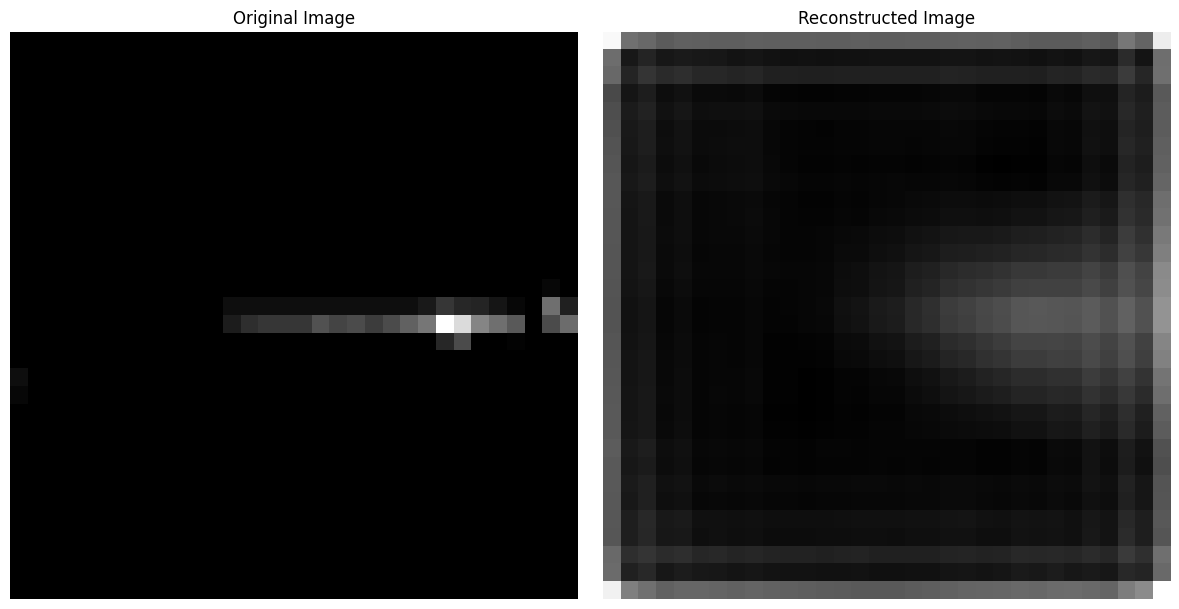

In [18]:
index=2
a=loaded_autoencoder.predict(np.expand_dims(x_train[index], axis=0))
# Visualizar o primeiro exemplo
plt.figure(figsize=(12, 6))
# Exibir a imagem original
plt.subplot(1, 2, 1)
plt.imshow(x_train[index], cmap='gray')  # Adapte o cmap se necessário
plt.title('Original Image')
plt.axis('off')  # Desliga os eixos
# Exibir a imagem reconstruída
plt.subplot(1, 2, 2)
plt.imshow(a[0], cmap='gray')  # Adapte o cmap se necessário
plt.title('Reconstructed Image')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()
plt.show()